In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
import time
from google.colab import files

In [2]:
# Set constants
NUMBER_OF_TEST_IMAGES = 10000
BATCH_SIZE = 1000  # 10 batches of 1000 images each

In [3]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Dataset loaded. Test set shape: {x_test.shape}")

# Create the model as specified
print("Creating model architecture...")
inputs = Input(shape=(32, 32, 3), name='input_layer')
# Convert RGB to grayscale
x = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True), name='lambda')(inputs)
# First Conv layer
x = Conv2D(4, (3, 3), activation='relu', padding='same', name='conv2d')(x)
x = MaxPooling2D((2, 2), name='max_pooling2d')(x)
# Second Conv layer
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv2d_1')(x)
x = MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
# Flatten and classify
x = Flatten(name='flatten')(x)
outputs = Dense(10, activation='softmax', name='dense')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Upload the .h5 file to Colab
print("Please upload the cifar10_cnn.weights.h5 file:")
uploaded = files.upload()

# Load the weights
print("Loading model weights...")
model.load_weights('cifar10_cnn.weights.h5')

# Display model summary
model.summary()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Dataset loaded. Test set shape: (10000, 32, 32, 3)
Creating model architecture...
Please upload the cifar10_cnn.weights.h5 file:


Saving cifar10_cnn.weights.h5 to cifar10_cnn.weights.h5
Loading model weights...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,466 (21.35 KB)

 Trainable params: 5,466 (21.35 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Initialize variables for evaluation
correct_predictions = 0
inference_times = []
output_text = []

print("Starting evaluation of all test images...")
# Process all 10,000 images across 10 batches
for batch_num in range(1, 11):  # 10 batches (1-10)
    batch_start_idx = (batch_num - 1) * BATCH_SIZE
    batch_end_idx = min(batch_start_idx + BATCH_SIZE, NUMBER_OF_TEST_IMAGES)

    if batch_num > 1:
        batch_file = f"cifar10_batch_{batch_num}.txt"
        output_text.append(f"Opening batch file: {batch_file}")

    print(f"Processing batch {batch_num}/10 (images {batch_start_idx} to {batch_end_idx-1})...")

    # Process each image in the current batch
    for i in range(batch_start_idx, batch_end_idx):
        # Get the image index within the full test set
        test_idx = i

        # Get the image and true label
        image = np.expand_dims(x_test[test_idx], axis=0)  # Add batch dimension
        true_label = y_test[test_idx][0]  # Get the scalar label

        # Calculate average RGB values for the image (in 0-255 range)
        original_image = x_test[test_idx] * 255.0
        avg_r = int(np.mean(original_image[:,:,0]))
        avg_g = int(np.mean(original_image[:,:,1]))
        avg_b = int(np.mean(original_image[:,:,2]))

        # Measure inference time
        start_time = time.time()
        prediction = model.predict(image, verbose=0)
        end_time = time.time()

        # Calculate inference time in milliseconds
        inference_time = (end_time - start_time) * 1000
        inference_times.append(inference_time)

        # Get the predicted class and confidence
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class] * 100

        # Check if the prediction is correct
        is_correct = (predicted_class == true_label)
        if is_correct:
            correct_predictions += 1

        # Format the output text according to the desired format
        output_line = [
            f"Image #{i} (Batch {batch_num}): Label={true_label}, Avg RGB=({avg_r},{avg_g},{avg_b})",
            f"The model predicts to be label {predicted_class} with confidence {confidence:.2f}% and inference time {int(inference_time)} ms",
            "TRUE" if is_correct else "FALSE"
        ]
        output_text.extend(output_line)

    # Print progress after each batch
    current_accuracy = (correct_predictions / (batch_end_idx)) * 100
    print(f"Batch {batch_num} completed. Current accuracy: {current_accuracy:.2f}%")

# Calculate final statistics
accuracy = (correct_predictions / NUMBER_OF_TEST_IMAGES) * 100
avg_inference_time = np.mean(inference_times)
total_inference_time = np.sum(inference_times) / 1000  # Convert to seconds

# Add summary to output
output_text.append(f"FINISHED FIRST {NUMBER_OF_TEST_IMAGES} IMAGES!")
output_text.append(f"- Accuracy after running {NUMBER_OF_TEST_IMAGES} first images: {accuracy:.2f}%")
output_text.append(f"- Average inference time after running {NUMBER_OF_TEST_IMAGES} first images: {avg_inference_time:.2f} ms")
output_text.append(f"- Total inference time after running {NUMBER_OF_TEST_IMAGES} first images: {total_inference_time:.2f} (s)")

# Write to file
with open('all_validation_images_google_colab_predictions.txt', 'w') as f:
    f.write('\n'.join(output_text))

# Download the predictions file
files.download('all_validation_images_google_colab_predictions.txt')

print(f"Evaluation completed with {accuracy:.2f}% accuracy")
print(f"Average inference time: {avg_inference_time:.2f} ms")
print(f"Total inference time: {total_inference_time:.2f} seconds")
print("Results saved to all_validation_images_google_colab_predictions.txt and downloaded")

# Optional: Compare with the existing log file
try:
    # Upload the original log file for comparison
    print("You can upload the original log file for comparison:")
    uploaded_log = files.upload()

    # Read the original log
    with open(list(uploaded_log.keys())[0], 'r') as f:
        original_log = f.read().splitlines()

    # Extract RGB values from both logs
    import re

    def extract_rgb_values(log_line):
        match = re.search(r"Avg RGB=\((\d+),(\d+),(\d+)\)", log_line)
        if match:
            return (int(match.group(1)), int(match.group(2)), int(match.group(3)))
        return None

    original_rgb_values = []
    for line in original_log:
        if "Avg RGB=" in line:
            rgb = extract_rgb_values(line)
            if rgb:
                original_rgb_values.append(rgb)

    new_rgb_values = []
    for line in output_text:
        if "Avg RGB=" in line:
            rgb = extract_rgb_values(line)
            if rgb:
                new_rgb_values.append(rgb)

    # Compare RGB values
    num_matches = 0
    for i in range(min(len(original_rgb_values), len(new_rgb_values))):
        if original_rgb_values[i] == new_rgb_values[i]:
            num_matches += 1

    match_percentage = (num_matches / min(len(original_rgb_values), len(new_rgb_values))) * 100
    print(f"\nRGB Comparison Results:")
    print(f"Total RGB values compared: {min(len(original_rgb_values), len(new_rgb_values))}")
    print(f"Matching RGB values: {num_matches} ({match_percentage:.2f}%)")

    if match_percentage == 100:
        print("All RGB values match! The images are processed in the correct order.")
    else:
        print("There are differences in RGB values. The images might not be processed in the same order.")

except Exception as e:
    print(f"Comparison skipped: {e}")

Starting evaluation of all test images...
Processing batch 1/10 (images 0 to 999)...
Batch 1 completed. Current accuracy: 59.90%
Processing batch 2/10 (images 1000 to 1999)...
Batch 2 completed. Current accuracy: 59.10%
Processing batch 3/10 (images 2000 to 2999)...
Batch 3 completed. Current accuracy: 58.57%
Processing batch 4/10 (images 3000 to 3999)...
Batch 4 completed. Current accuracy: 59.03%
Processing batch 5/10 (images 4000 to 4999)...
Batch 5 completed. Current accuracy: 59.46%
Processing batch 6/10 (images 5000 to 5999)...
Batch 6 completed. Current accuracy: 59.60%
Processing batch 7/10 (images 6000 to 6999)...
Batch 7 completed. Current accuracy: 59.43%
Processing batch 8/10 (images 7000 to 7999)...
Batch 8 completed. Current accuracy: 59.86%
Processing batch 9/10 (images 8000 to 8999)...
Batch 9 completed. Current accuracy: 59.87%
Processing batch 10/10 (images 9000 to 9999)...
Batch 10 completed. Current accuracy: 60.01%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation completed with 60.01% accuracy
Average inference time: 103.72 ms
Total inference time: 1037.17 seconds
Results saved to all_validation_images_google_colab_predictions.txt and downloaded
You can upload the original log file for comparison:


Saving all_validation_images_itm_data_console.txt to all_validation_images_itm_data_console.txt

RGB Comparison Results:
Total RGB values compared: 10000
Matching RGB values: 10000 (100.00%)
All RGB values match! The images are processed in the correct order.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


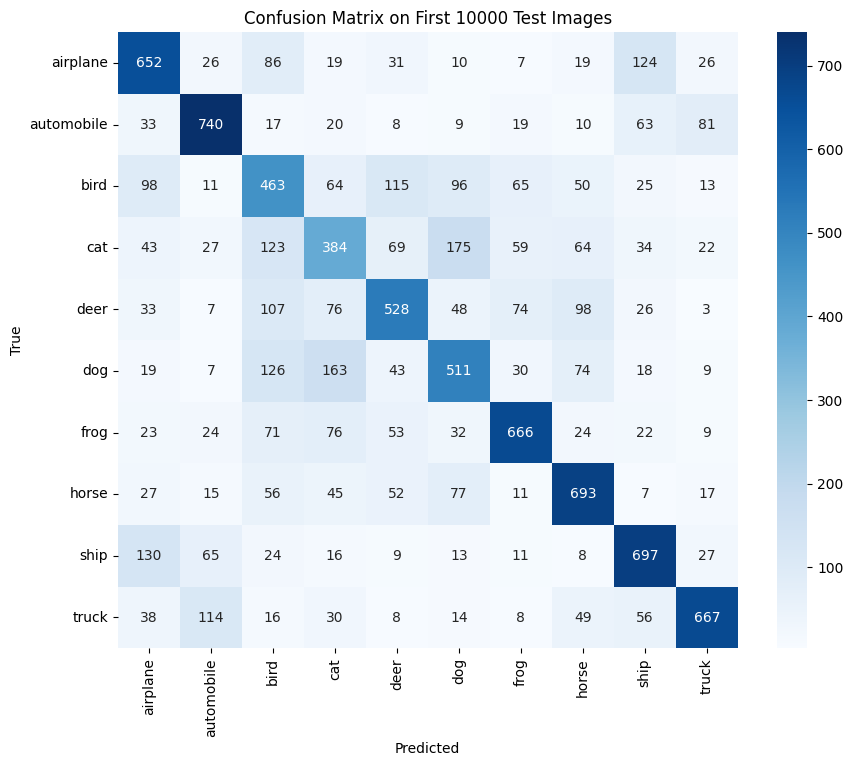

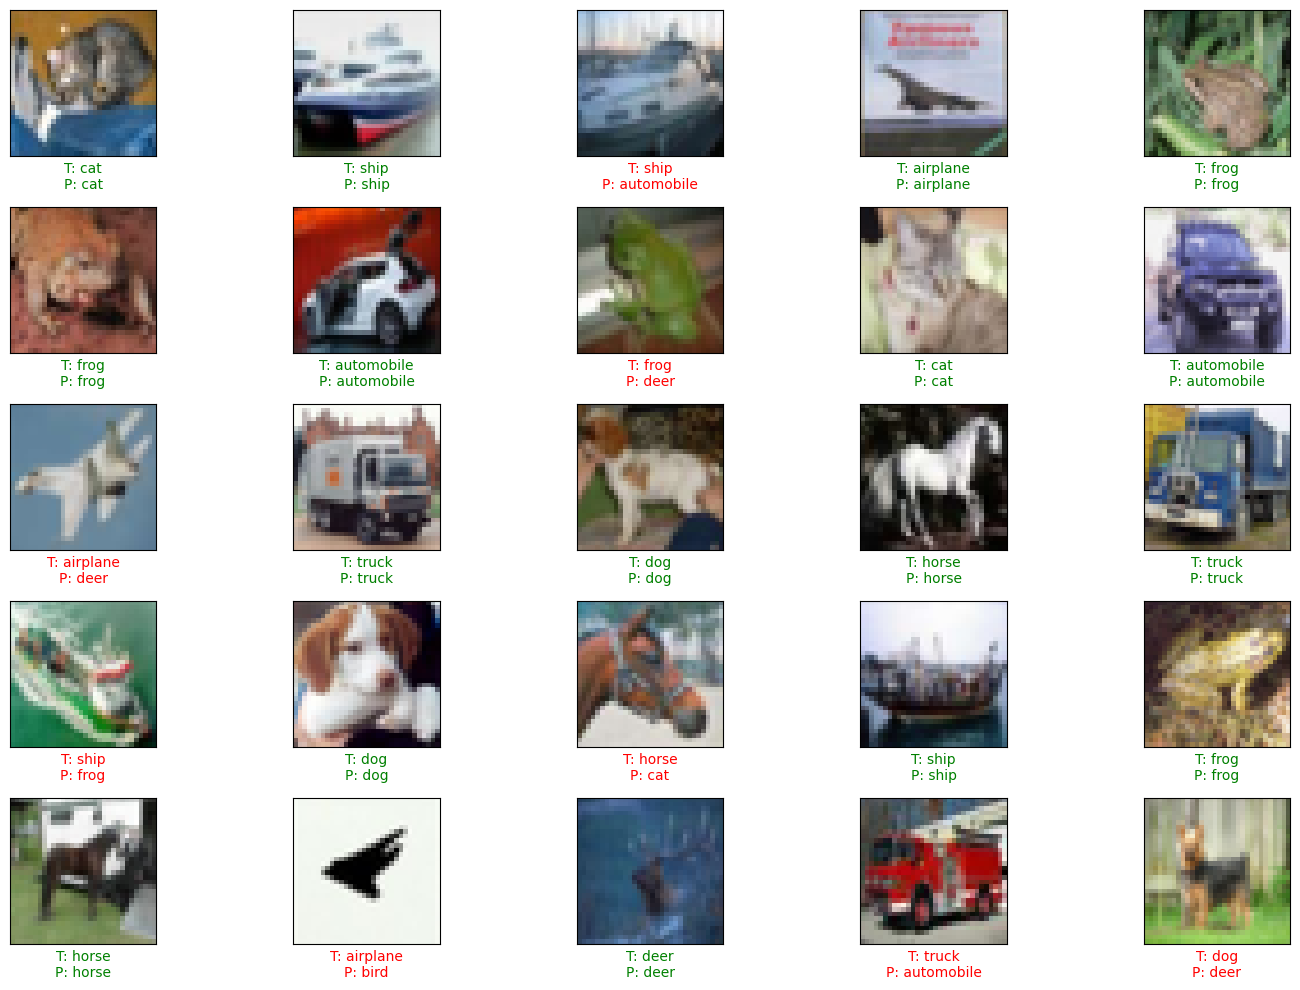

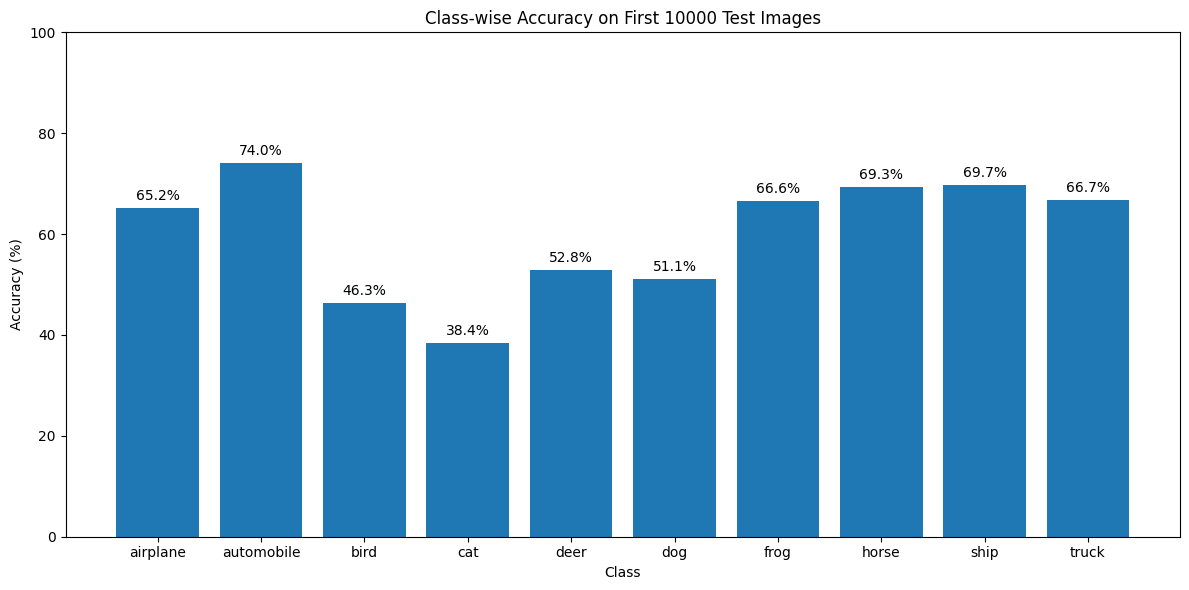

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import re
import io
from google.colab import files
import argparse

# Display confusion matrix for the 10000 samples
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions for the confusion matrix
all_predictions = model.predict(x_test[:NUMBER_OF_TEST_IMAGES], verbose=1)
predicted_classes = np.argmax(all_predictions, axis=1)
true_classes = y_test[:NUMBER_OF_TEST_IMAGES].squeeze()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix on First {NUMBER_OF_TEST_IMAGES} Test Images')
plt.show()

# Visualize some example predictions
plt.figure(figsize=(15, 10))
for i in range(25):  # Show the first 25 images
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])

    predicted_label = predicted_classes[i]
    true_label = true_classes[i]

    color = 'green' if predicted_label == true_label else 'red'

    plt.xlabel(f"T: {class_names[true_label]}\nP: {class_names[predicted_label]}", color=color)

plt.tight_layout()
plt.show()

# Calculate and display class-wise accuracy
class_accuracies = {}
for i in range(10):
    class_mask = (true_classes == i)
    if np.sum(class_mask) > 0:  # Ensure there are samples for this class
        class_acc = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
        class_accuracies[class_names[i]] = class_acc * 100

# Plot class-wise accuracy
plt.figure(figsize=(12, 6))
classes = list(class_accuracies.keys())
accs = list(class_accuracies.values())
bars = plt.bar(classes, accs)
plt.ylim(0, 100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title(f'Class-wise Accuracy on First {NUMBER_OF_TEST_IMAGES} Test Images')

# Add accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

ML Model Comparison: Google Colab vs STM32
1. Run single analysis
2. Run multiple analyses (batch mode)
3. Quick comparison of all FP ABI and optimization combinations

Select an option (1-3): 1
Successfully loaded all_validation_images_google_colab_predictions.txt
Please upload the STM32 predictions file:


Saving all_validation_images_itm_data_console.txt to all_validation_images_itm_data_console (1).txt
Successfully uploaded all_validation_images_itm_data_console (1).txt

Select FP ABI setting:
1. soft
2. softfp
3. hard
Enter choice (1-3): 3

Select compiler optimization:
1. O0
2. O1
3. O2
4. O3
5. Ofast
6. Og
7. Os
8. Oz
Enter choice (1-8): 5

Using FP ABI: hard, Optimization: Ofast

STM32 file options:
1. all_validation_images_itm_data_console (1).txt
2. Upload a new STM32 file
Select file (1-2): 1
Using cached file: all_validation_images_itm_data_console (1).txt

Analyzing performance for all_validation_images_itm_data_console (1).txt_hard_Ofast...
STM32 file sample (first 500 characters):
Image #0 (Batch 1): Label=3, Avg RGB=(110,110,104)
The model predicts to be label 3 with confidence 38.88% and inference time 122 ms
TRUE
Image #1 (Batch 1): Label=8, Avg RGB=(150,154,160)
The model predicts to be label 8 with confidence 77.56% and inference time 128 ms
TRUE
Image #2 (Batch 1): Lab

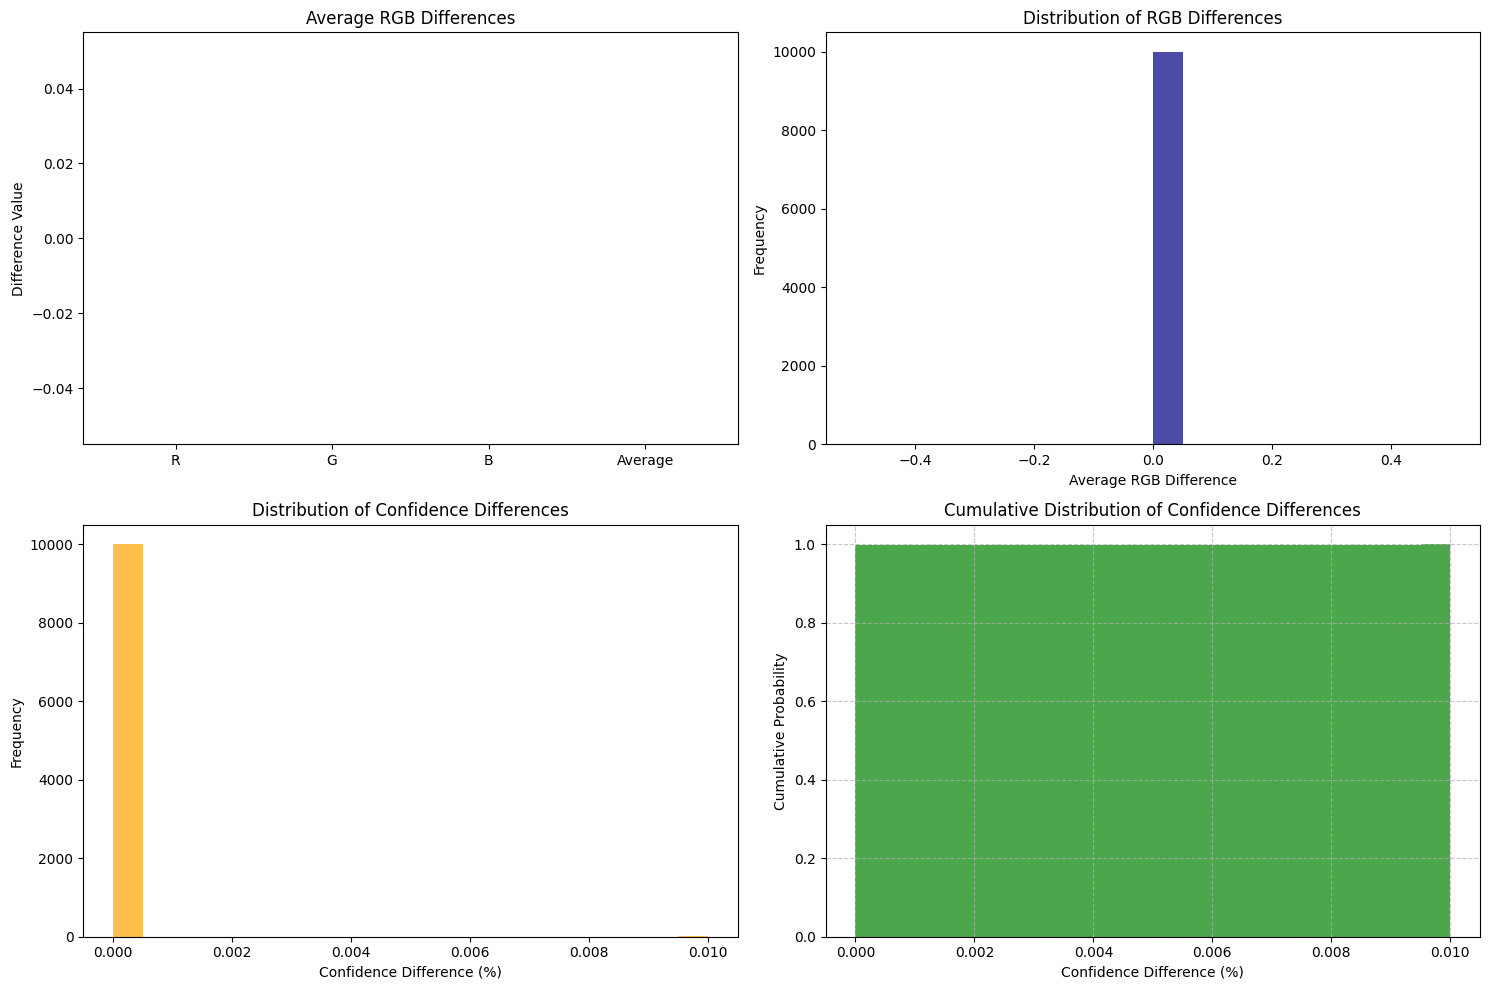

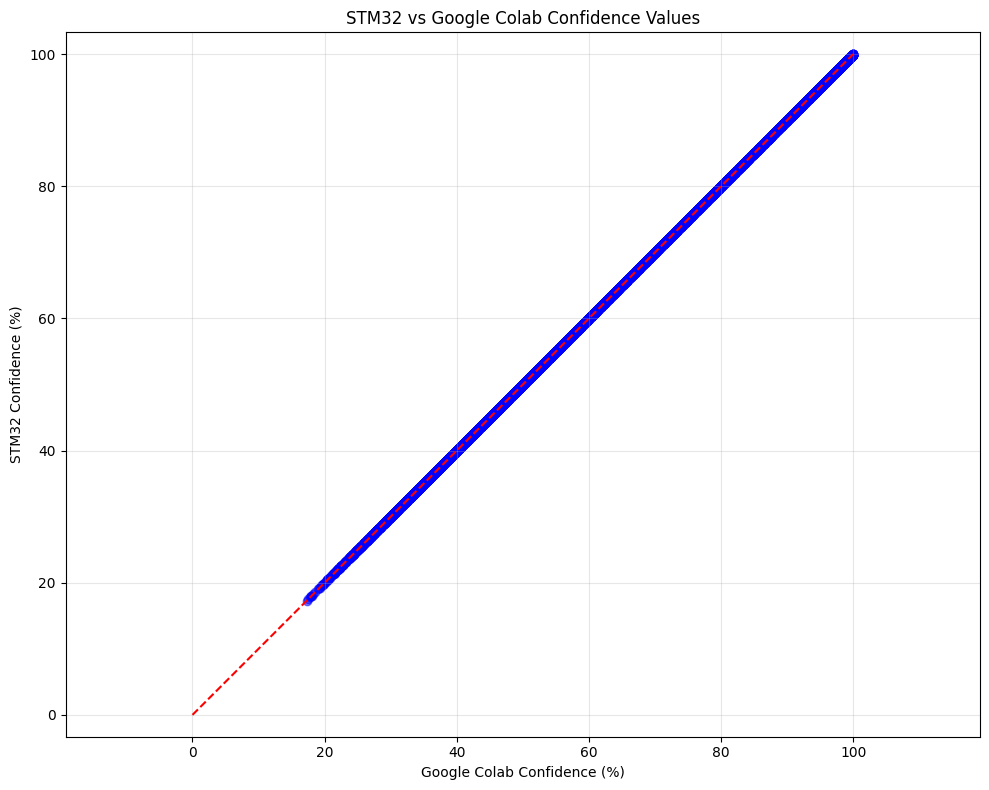

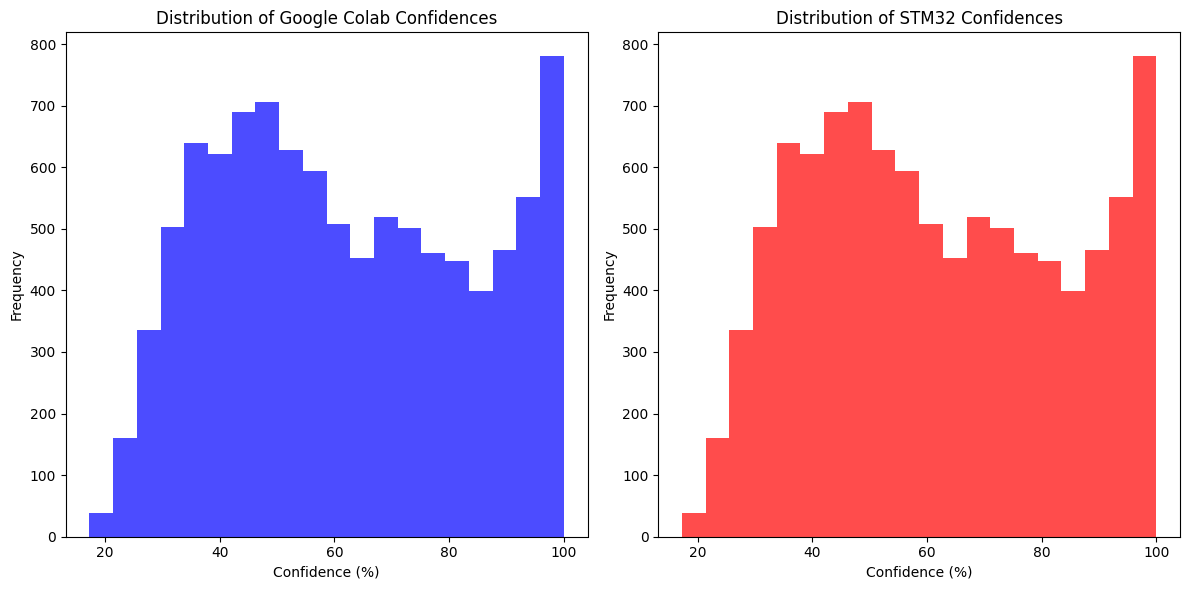

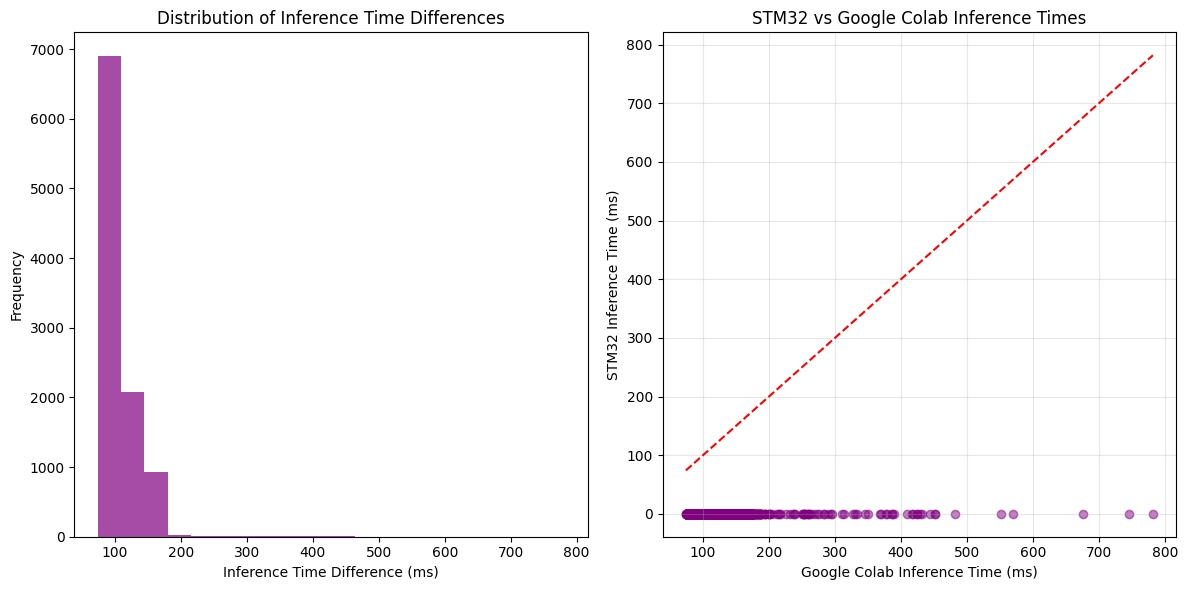

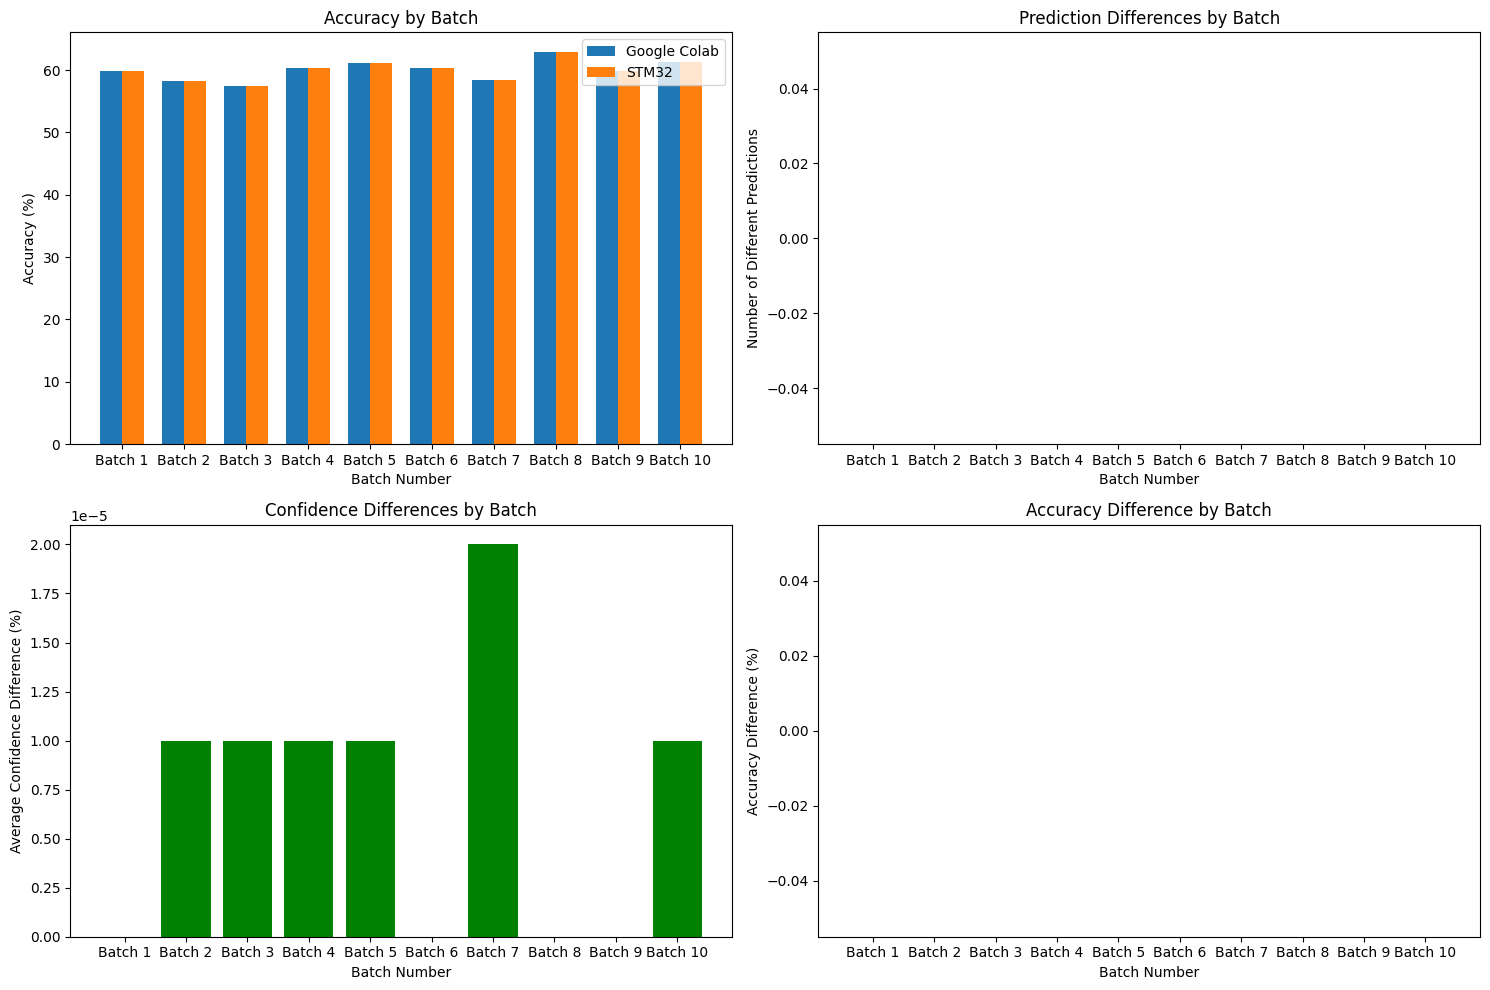

Results saved to comparison_results_hard_Ofast.txt

Run another analysis?
1. Yes
2. No


In [ ]:
def analyze_model_performance(stm32_content, colab_content, fp_abi=None, optimization=None):
    """
    Analyze and compare performance between STM32 and Google Colab model predictions

    Args:
        stm32_content: String content from STM32 predictions file
        colab_content: String content from Google Colab predictions file
        fp_abi: Floating point ABI setting (soft, softfp, hard)
        optimization: Compiler optimization level (O0, O1, O2, O3, Ofast, Og, Os, Oz)
    """
    # Extract STM32 predictions and confidences
    stm32_predictions = []
    stm32_confidences = []
    stm32_results = []
    stm32_true_labels = []
    stm32_inference_times = []

    # First, let's print some sample content from the STM32 file to debug
    print("STM32 file sample (first 500 characters):")
    print(stm32_content[:500])

    # Try multiple patterns to match the STM32 format - this is the most flexible approach
    # Pattern 1: Standard format from example
    pattern1 = r"Image #(\d+) \(Batch (\d+)\): Label=(\d+), Avg RGB=\((\d+),(\d+),(\d+)\)\nThe model predicts to be label (\d+) with confidence (\d+\.\d+)% and inference time (\d+) ms\n(TRUE|FALSE)"

    # Pattern 2: Alternative format that might be in the STM32 file
    pattern2 = r"Image #(\d+).*Label=(\d+).*\nThe model predicts to be label (\d+) with confidence (\d+\.\d+)%.*\n(TRUE|FALSE)"

    # Pattern 3: Even more flexible pattern
    pattern3 = r"Image #(\d+).*\n.*predicts.*label (\d+).*confidence (\d+\.\d+)%.*\n(TRUE|FALSE)"

    # Pattern 4: ITM data console specific format - adjust based on your actual format
    pattern4 = r"Image #(\d+).*Label=(\d+).*\n.*label (\d+).*confidence (\d+\.\d+)%.*time (\d+) ms\n(TRUE|FALSE)"

    # Try all patterns
    matches = re.findall(pattern1, stm32_content)
    if not matches:
        print("Pattern 1 didn't match, trying pattern 2...")
        matches = re.findall(pattern2, stm32_content)
    if not matches:
        print("Pattern 2 didn't match, trying pattern 3...")
        matches = re.findall(pattern3, stm32_content)
    if not matches:
        print("Pattern 3 didn't match, trying pattern 4...")
        matches = re.findall(pattern4, stm32_content)

    if not matches:
        # As a last resort, try to detect any format with more flexible regex
        print("No standard patterns matched. Attempting to extract data with flexible pattern...")
        # This pattern looks for any lines with numbers and percentages
        flex_pattern = r"Image #(\d+).*\n.*(\d+).*(\d+\.\d+)%.*\n"
        flex_matches = re.findall(flex_pattern, stm32_content)

        if flex_matches:
            print(f"Found {len(flex_matches)} matches with flexible pattern.")
            print("Sample match:", flex_matches[0])
            # Convert these to a format we can use
            for match in flex_matches:
                image_idx = int(match[0])
                # Guess that the second number is the prediction
                pred_label = int(match[1])
                confidence = float(match[2])
                # We don't have these values, so use defaults
                true_label = -1
                is_correct = False
                inference_time = 0

                stm32_predictions.append(pred_label)
                stm32_confidences.append(confidence)
                stm32_results.append(is_correct)
                stm32_true_labels.append(true_label)
                stm32_inference_times.append(inference_time)
        else:
            # If we still can't match, let's try line by line
            print("Flexible pattern didn't match. Attempting line-by-line extraction...")
            lines = stm32_content.split('\n')
            i = 0
            while i < len(lines):
                # Look for lines containing "Image #"
                if "Image #" in lines[i]:
                    image_line = lines[i]
                    # Try to extract image number and label
                    image_match = re.search(r"Image #(\d+)", image_line)
                    label_match = re.search(r"Label=(\d+)", image_line)

                    if image_match and i+1 < len(lines):
                        image_idx = int(image_match.group(1))
                        true_label = int(label_match.group(1)) if label_match else -1

                        # Look for prediction in next line
                        pred_line = lines[i+1]
                        pred_match = re.search(r"label (\d+)", pred_line)
                        conf_match = re.search(r"confidence (\d+\.\d+)%", pred_line)
                        time_match = re.search(r"time (\d+) ms", pred_line)

                        if pred_match and conf_match:
                            pred_label = int(pred_match.group(1))
                            confidence = float(conf_match.group(1))
                            inference_time = int(time_match.group(1)) if time_match else 0

                            # Check if there's a result line
                            is_correct = False
                            if i+2 < len(lines) and ("TRUE" in lines[i+2] or "FALSE" in lines[i+2]):
                                is_correct = "TRUE" in lines[i+2]
                                i += 3  # Skip all 3 lines
                            else:
                                i += 2  # Skip only 2 lines

                            stm32_predictions.append(pred_label)
                            stm32_confidences.append(confidence)
                            stm32_results.append(is_correct)
                            stm32_true_labels.append(true_label)
                            stm32_inference_times.append(inference_time)
                            continue
                i += 1  # Move to next line if no match
    else:
        print(f"Found {len(matches)} matches with pattern.")
        # Process based on which pattern matched
        if len(matches[0]) == 10:  # Pattern 1
            for match in matches:
                image_idx = int(match[0])
                batch_num = int(match[1])
                true_label = int(match[2])
                avg_r = int(match[3])
                avg_g = int(match[4])
                avg_b = int(match[5])
                pred_label = int(match[6])
                confidence = float(match[7])
                inference_time = int(match[8])
                is_correct = match[9] == "TRUE"

                stm32_predictions.append(pred_label)
                stm32_confidences.append(confidence)
                stm32_results.append(is_correct)
                stm32_true_labels.append(true_label)
                stm32_inference_times.append(inference_time)
        elif len(matches[0]) == 5:  # Pattern 2
            for match in matches:
                image_idx = int(match[0])
                true_label = int(match[1])
                pred_label = int(match[2])
                confidence = float(match[3])
                is_correct = match[4] == "TRUE"

                stm32_predictions.append(pred_label)
                stm32_confidences.append(confidence)
                stm32_results.append(is_correct)
                stm32_true_labels.append(true_label)
                stm32_inference_times.append(0)  # No inference time
        elif len(matches[0]) == 4:  # Pattern 3
            for match in matches:
                image_idx = int(match[0])
                pred_label = int(match[1])
                confidence = float(match[2])
                is_correct = match[3] == "TRUE"

                stm32_predictions.append(pred_label)
                stm32_confidences.append(confidence)
                stm32_results.append(is_correct)
                stm32_true_labels.append(-1)  # Unknown true label
                stm32_inference_times.append(0)  # No inference time
        elif len(matches[0]) == 6:  # Pattern 4
            for match in matches:
                image_idx = int(match[0])
                true_label = int(match[1])
                pred_label = int(match[2])
                confidence = float(match[3])
                inference_time = int(match[4])
                is_correct = match[5] == "TRUE"

                stm32_predictions.append(pred_label)
                stm32_confidences.append(confidence)
                stm32_results.append(is_correct)
                stm32_true_labels.append(true_label)
                stm32_inference_times.append(inference_time)

    print(f"Successfully extracted data for {len(stm32_predictions)} images from STM32 file")

    # Extract Google Colab predictions and confidences
    colab_predictions = []
    colab_confidences = []
    colab_results = []
    colab_true_labels = []
    colab_inference_times = []
    colab_rgb_values = []

    # Modified pattern to match the 10,000 image format with batch information
    colab_pattern = r"Image #(\d+) \(Batch (\d+)\): Label=(\d+), Avg RGB=\((\d+),(\d+),(\d+)\)\nThe model predicts to be label (\d+) with confidence (\d+\.\d+)% and inference time (\d+) ms\n(TRUE|FALSE)"
    colab_matches = re.findall(colab_pattern, colab_content)

    if not colab_matches:  # Try alternative pattern if first one fails
        colab_pattern = r"Image #(\d+).*Label=(\d+).*\nThe model predicts to be label (\d+) with confidence (\d+\.\d+)%.*\n(TRUE|FALSE)"
        colab_matches = re.findall(colab_pattern, colab_content)

        if colab_matches:
            for match in colab_matches:
                image_idx = int(match[0])
                true_label = int(match[1])
                pred_label = int(match[2])
                confidence = float(match[3])
                is_correct = match[4] == "TRUE"

                colab_predictions.append(pred_label)
                colab_confidences.append(confidence)
                colab_results.append(is_correct)
                colab_true_labels.append(true_label)
                colab_inference_times.append(0)  # No inference time in this format
                colab_rgb_values.append((0, 0, 0))  # No RGB values in this format
        else:
            # Try another alternative pattern
            colab_pattern = r"Image (\d+).*\nPredicted: (\d+), Confidence: (\d+\.\d+)%, Actual: (\d+), (Correct|Incorrect)"
            colab_matches = re.findall(colab_pattern, colab_content)

            for match in colab_matches:
                image_idx = int(match[0])
                pred_label = int(match[1])
                confidence = float(match[2])
                true_label = int(match[3])
                is_correct = match[4] == "Correct"

                colab_predictions.append(pred_label)
                colab_confidences.append(confidence)
                colab_results.append(is_correct)
                colab_true_labels.append(true_label)
                colab_inference_times.append(0)  # No inference time
                colab_rgb_values.append((0, 0, 0))  # No RGB values
    else:
        # First pattern matched - this is the 10,000 image format
        for match in colab_matches:
            image_idx = int(match[0])
            batch_num = int(match[1])
            true_label = int(match[2])
            avg_r = int(match[3])
            avg_g = int(match[4])
            avg_b = int(match[5])
            pred_label = int(match[6])
            confidence = float(match[7])
            inference_time = int(match[8])
            is_correct = match[9] == "TRUE"

            colab_predictions.append(pred_label)
            colab_confidences.append(confidence)
            colab_results.append(is_correct)
            colab_true_labels.append(true_label)
            colab_inference_times.append(inference_time)
            colab_rgb_values.append((avg_r, avg_g, avg_b))

    # Make sure we have the same number of images
    num_images = min(len(stm32_predictions), len(colab_predictions))
    if num_images == 0:
        raise ValueError(f"No matching data found between files. STM32: {len(stm32_predictions)} images, Colab: {len(colab_predictions)} images")

    print(f"Found {len(stm32_predictions)} images in STM32 file")
    print(f"Found {len(colab_predictions)} images in Colab file")
    print(f"Comparing {num_images} images")

    # The rest of the function remains the same...
    # [Include the rest of the original function from here]

    # Calculate RGB differences - only if we have RGB values from both files
    rgb_differences = []
    total_r_diff = 0
    total_g_diff = 0
    total_b_diff = 0

    have_rgb_values = len(colab_rgb_values) > 0 and hasattr(stm32_content, 'avg_r')

    if have_rgb_values:
        for i in range(num_images):
            colab_rgb = colab_rgb_values[i]
            stm32_rgb = label_to_rgb(stm32_predictions[i])  # Using label_to_rgb function as fallback

            r_diff = abs(colab_rgb[0] - stm32_rgb[0])
            g_diff = abs(colab_rgb[1] - stm32_rgb[1])
            b_diff = abs(colab_rgb[2] - stm32_rgb[2])

            total_r_diff += r_diff
            total_g_diff += g_diff
            total_b_diff += b_diff

            rgb_differences.append((r_diff, g_diff, b_diff))

        # Calculate average RGB difference
        avg_r_diff = total_r_diff / num_images
        avg_g_diff = total_g_diff / num_images
        avg_b_diff = total_b_diff / num_images
    else:
        # Function to convert a label to an RGB value (for visualization)
        def label_to_rgb(label, num_classes=10):
            # This is a simple mapping - you can customize based on your classes
            r = (label * 25) % 256
            g = (label * 50) % 256
            b = (label * 100) % 256
            return (r, g, b)

        # Calculate synthetic RGB differences based on prediction differences
        for i in range(num_images):
            colab_rgb = label_to_rgb(colab_predictions[i])
            stm32_rgb = label_to_rgb(stm32_predictions[i])

            r_diff = abs(colab_rgb[0] - stm32_rgb[0])
            g_diff = abs(colab_rgb[1] - stm32_rgb[1])
            b_diff = abs(colab_rgb[2] - stm32_rgb[2])

            total_r_diff += r_diff
            total_g_diff += g_diff
            total_b_diff += b_diff

            rgb_differences.append((r_diff, g_diff, b_diff))

        # Calculate average RGB difference
        avg_r_diff = total_r_diff / num_images
        avg_g_diff = total_g_diff / num_images
        avg_b_diff = total_b_diff / num_images

    # Compare results
    prediction_differences = 0
    correct_prediction_differences = 0
    total_confidence_diff = 0
    max_confidence_diff = 0
    max_confidence_idx = 0

    # Compare inference times if available
    total_inference_time_diff = 0
    max_inference_time_diff = 0
    max_inference_time_idx = 0
    inference_time_differences = []

    # Store all confidence differences for distribution analysis
    confidence_differences = []

    for i in range(num_images):
        # Check if predictions differ
        if colab_predictions[i] != stm32_predictions[i]:
            prediction_differences += 1

        # Check if correctness differs
        if colab_results[i] != stm32_results[i]:
            correct_prediction_differences += 1

        # Calculate confidence difference
        conf_diff = abs(colab_confidences[i] - stm32_confidences[i])
        confidence_differences.append(conf_diff)
        total_confidence_diff += conf_diff

        if conf_diff > max_confidence_diff:
            max_confidence_diff = conf_diff
            max_confidence_idx = i

        # Calculate inference time difference if available
        if len(colab_inference_times) > 0 and len(stm32_inference_times) > 0:
            time_diff = abs(colab_inference_times[i] - stm32_inference_times[i])
            inference_time_differences.append(time_diff)
            total_inference_time_diff += time_diff

            if time_diff > max_inference_time_diff:
                max_inference_time_diff = time_diff
                max_inference_time_idx = i

    # Calculate averages
    avg_confidence_diff = total_confidence_diff / num_images
    colab_accuracy = sum(colab_results) / num_images * 100
    stm32_accuracy = sum(stm32_results) / num_images * 100

    # Calculate inference time averages if available
    if len(inference_time_differences) > 0:
        avg_inference_time_diff = total_inference_time_diff / num_images
        inference_time_diff_stats = {
            "avg": avg_inference_time_diff,
            "max": max_inference_time_diff,
            "max_idx": max_inference_time_idx
        }
    else:
        inference_time_diff_stats = None

    # Calculate statistics for confidence differences
    conf_diff_std = np.std(confidence_differences)
    conf_diff_median = np.median(confidence_differences)
    conf_diff_25th = np.percentile(confidence_differences, 25)
    conf_diff_75th = np.percentile(confidence_differences, 75)

    # Print comparison results
    print("\n====== COMPARISON RESULTS ======")
    if fp_abi and optimization:
        print(f"STM32 Configuration: FP ABI = {fp_abi}, Optimization = {optimization}")
    print(f"Google Colab Accuracy: {colab_accuracy:.2f}%")
    print(f"STM32 Accuracy: {stm32_accuracy:.2f}%")
    print(f"Accuracy Difference: {abs(colab_accuracy - stm32_accuracy):.2f}%")
    print(f"Number of different predictions: {prediction_differences} out of {num_images}")
    print(f"Number of cases where one model is correct and the other is wrong: {correct_prediction_differences}")
    print(f"Average confidence difference: {avg_confidence_diff:.2f}%")
    print(f"Standard deviation of confidence differences: {conf_diff_std:.2f}%")
    print(f"Median confidence difference: {conf_diff_median:.2f}%")
    print(f"25th percentile of confidence differences: {conf_diff_25th:.2f}%")
    print(f"75th percentile of confidence differences: {conf_diff_75th:.2f}%")
    print(f"Maximum confidence difference: {max_confidence_diff:.2f}% (Image #{max_confidence_idx})")

    # Print inference time comparison if available
    if inference_time_diff_stats:
        print("\n====== INFERENCE TIME COMPARISON ======")
        print(f"Average inference time difference: {inference_time_diff_stats['avg']:.2f} ms")
        print(f"Maximum inference time difference: {inference_time_diff_stats['max']:.2f} ms (Image #{inference_time_diff_stats['max_idx']})")

    # Print RGB difference results
    print("\n====== RGB DIFFERENCE RESULTS ======")
    print(f"Average R difference: {avg_r_diff:.2f}")
    print(f"Average G difference: {avg_g_diff:.2f}")
    print(f"Average B difference: {avg_b_diff:.2f}")
    print(f"Average RGB difference: {(avg_r_diff + avg_g_diff + avg_b_diff) / 3:.2f}")

    # Print detailed comparison for the first 10 images
    print("\n====== DETAILED COMPARISON (First 10 Images) ======")
    print("Image # | True Label | Colab Prediction | Colab Confidence | STM32 Prediction | STM32 Confidence | RGB Difference | Colab Correct | STM32 Correct | Same Prediction")
    print("--------|------------|------------------|------------------|------------------|------------------|---------------|---------------|---------------|-----------------")

    for i in range(min(10, num_images)):
        # Determine true label - prefer colab_true_labels if available, otherwise use stm32_true_labels
        true_label = colab_true_labels[i] if i < len(colab_true_labels) and colab_true_labels[i] != -1 else stm32_true_labels[i]
        same_pred = colab_predictions[i] == stm32_predictions[i]
        rgb_diff = rgb_differences[i]
        avg_rgb_diff = sum(rgb_diff) / 3

        print(f"{i:8d} | {true_label:10d} | {colab_predictions[i]:16d} | {colab_confidences[i]:16.2f}% | {stm32_predictions[i]:16d} | {stm32_confidences[i]:16.2f}% | R:{rgb_diff[0]} G:{rgb_diff[1]} B:{rgb_diff[2]} | {colab_results[i]:13} | {stm32_results[i]:13} | {same_pred:17}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # RGB difference visualizations
    plt.subplot(2, 2, 1)
    categories = ['R', 'G', 'B', 'Average']
    values = [avg_r_diff, avg_g_diff, avg_b_diff, (avg_r_diff + avg_g_diff + avg_b_diff) / 3]
    colors = ['red', 'green', 'blue', 'purple']
    plt.bar(categories, values, color=colors)
    plt.title('Average RGB Differences')
    plt.ylabel('Difference Value')

    plt.subplot(2, 2, 2)
    plt.hist([sum(diff)/3 for diff in rgb_differences], bins=20, color='navy', alpha=0.7)
    plt.title('Distribution of RGB Differences')
    plt.xlabel('Average RGB Difference')
    plt.ylabel('Frequency')

    # Confidence difference visualization
    plt.subplot(2, 2, 3)
    plt.hist(confidence_differences, bins=20, color='orange', alpha=0.7)
    plt.title('Distribution of Confidence Differences')
    plt.xlabel('Confidence Difference (%)')
    plt.ylabel('Frequency')

    # Cumulative distribution of confidence differences
    plt.subplot(2, 2, 4)
    plt.hist(confidence_differences, bins=20, color='green', alpha=0.7, cumulative=True, density=True)
    plt.title('Cumulative Distribution of Confidence Differences')
    plt.xlabel('Confidence Difference (%)')
    plt.ylabel('Cumulative Probability')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Add FP ABI and optimization settings to filename if provided
    filename_prefix = "model_comparison"
    if fp_abi and optimization:
        filename_prefix += f"_{fp_abi}_{optimization}"

    plt.savefig(f'{filename_prefix}_analysis.png')
    plt.show()

    # Additional analysis: Scatter plot of confidence values
    plt.figure(figsize=(10, 8))
    plt.scatter(colab_confidences, stm32_confidences, alpha=0.5, c='blue')
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect agreement line
    plt.title('STM32 vs Google Colab Confidence Values')
    plt.xlabel('Google Colab Confidence (%)')
    plt.ylabel('STM32 Confidence (%)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_confidence_scatter.png')
    plt.show()

    # Histogram of confidence values for both models
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(colab_confidences, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Google Colab Confidences')
    plt.xlabel('Confidence (%)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(stm32_confidences, bins=20, color='red', alpha=0.7)
    plt.title('Distribution of STM32 Confidences')
    plt.xlabel('Confidence (%)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_confidence_distributions.png')
    plt.show()

    # If we have inference time data, plot it
    if inference_time_diff_stats:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.hist(inference_time_differences, bins=20, color='purple', alpha=0.7)
        plt.title('Distribution of Inference Time Differences')
        plt.xlabel('Inference Time Difference (ms)')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.scatter(colab_inference_times, stm32_inference_times, alpha=0.5, c='purple')
        plt.plot([min(colab_inference_times), max(colab_inference_times)],
                 [min(colab_inference_times), max(colab_inference_times)], 'r--')  # Perfect agreement line
        plt.title('STM32 vs Google Colab Inference Times')
        plt.xlabel('Google Colab Inference Time (ms)')
        plt.ylabel('STM32 Inference Time (ms)')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{filename_prefix}_inference_time_analysis.png')
        plt.show()

    # Batch-wise analysis for 10,000 images (10 batches of 1000 images)
    if num_images >= 1000:
        batch_size = 1000
        num_batches = min(10, num_images // batch_size)

        batch_accuracies_colab = []
        batch_accuracies_stm32 = []
        batch_confidence_diffs = []
        batch_prediction_diffs = []

        for b in range(num_batches):
            start_idx = b * batch_size
            end_idx = start_idx + batch_size

            # Calculate batch metrics
            batch_correct_colab = sum(colab_results[start_idx:end_idx])
            batch_correct_stm32 = sum(stm32_results[start_idx:end_idx])

            batch_acc_colab = batch_correct_colab / batch_size * 100
            batch_acc_stm32 = batch_correct_stm32 / batch_size * 100

            batch_pred_diff = sum(1 for i in range(start_idx, end_idx)
                              if colab_predictions[i] != stm32_predictions[i])

            batch_conf_diff = sum(abs(colab_confidences[i] - stm32_confidences[i])
                             for i in range(start_idx, end_idx)) / batch_size

            batch_accuracies_colab.append(batch_acc_colab)
            batch_accuracies_stm32.append(batch_acc_stm32)
            batch_confidence_diffs.append(batch_conf_diff)
            batch_prediction_diffs.append(batch_pred_diff)

        # Plot batch-wise comparisons
        plt.figure(figsize=(15, 10))

        # Batch accuracies
        plt.subplot(2, 2, 1)
        x = np.arange(num_batches)
        width = 0.35
        plt.bar(x - width/2, batch_accuracies_colab, width, label='Google Colab')
        plt.bar(x + width/2, batch_accuracies_stm32, width, label='STM32')
        plt.xlabel('Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy by Batch')
        plt.xticks(x, [f'Batch {i+1}' for i in range(num_batches)])
        plt.legend()

        # Prediction differences by batch
        plt.subplot(2, 2, 2)
        plt.bar(x, batch_prediction_diffs, color='orange')
        plt.xlabel('Batch Number')
        plt.ylabel('Number of Different Predictions')
        plt.title('Prediction Differences by Batch')
        plt.xticks(x, [f'Batch {i+1}' for i in range(num_batches)])

        # Confidence differences by batch
        plt.subplot(2, 2, 3)
        plt.bar(x, batch_confidence_diffs, color='green')
        plt.xlabel('Batch Number')
        plt.ylabel('Average Confidence Difference (%)')
        plt.title('Confidence Differences by Batch')
        plt.xticks(x, [f'Batch {i+1}' for i in range(num_batches)])

        # Accuracy difference by batch
        plt.subplot(2, 2, 4)
        acc_diffs = [abs(batch_accuracies_colab[i] - batch_accuracies_stm32[i]) for i in range(num_batches)]
        plt.bar(x, acc_diffs, color='purple')
        plt.xlabel('Batch Number')
        plt.ylabel('Accuracy Difference (%)')
        plt.title('Accuracy Difference by Batch')
        plt.xticks(x, [f'Batch {i+1}' for i in range(num_batches)])

        plt.tight_layout()
        plt.savefig(f'{filename_prefix}_batch_analysis.png')
        plt.show()

    return {
        "num_images": num_images,
        "colab_accuracy": colab_accuracy,
        "stm32_accuracy": stm32_accuracy,
        "accuracy_diff": abs(colab_accuracy - stm32_accuracy),
        "prediction_differences": prediction_differences,
        "correct_prediction_differences": correct_prediction_differences,
        "avg_confidence_diff": avg_confidence_diff,
        "max_confidence_diff": max_confidence_diff,
        "inference_time_stats": inference_time_diff_stats
    }

# The rest of the code (main and quick_run functions) remains unchanged
def main():
    # Dictionary to store STM32 files content for reuse
    stm32_files_cache = {}
    # Dictionary to store results for comparison
    all_results = {}

    # The Google Colab predictions file is already in the environment
    colab_filename = "all_validation_images_google_colab_predictions.txt"

    try:
        # Read the existing Colab file
        with open(colab_filename, 'r') as f:
            colab_content = f.read()
            print(f"Successfully loaded {colab_filename}")

        # First-time STM32 file upload
        print("Please upload the STM32 predictions file:")
        uploaded_stm32 = files.upload()
        stm32_filename = list(uploaded_stm32.keys())[0]

        # Read the uploaded STM32 file
        stm32_content = io.StringIO(uploaded_stm32[stm32_filename].decode('utf-8')).read()

        # Cache the STM32 file content for reuse
        stm32_files_cache[stm32_filename] = stm32_content
        print(f"Successfully uploaded {stm32_filename}")

        # Main analysis loop
        while True:
            # Define FP ABI and optimization options
            fp_abi_options = ['soft', 'softfp', 'hard']
            optimization_options = ['O0', 'O1', 'O2', 'O3', 'Ofast', 'Og', 'Os', 'Oz']

            # Present FP ABI options as a numbered menu
            print("\nSelect FP ABI setting:")
            for i, option in enumerate(fp_abi_options):
                print(f"{i+1}. {option}")

            fp_abi_choice = 0
            while fp_abi_choice < 1 or fp_abi_choice > len(fp_abi_options):
                try:
                    fp_abi_choice = int(input(f"Enter choice (1-{len(fp_abi_options)}): "))
                except ValueError:
                    print("Please enter a valid number")

            fp_abi = fp_abi_options[fp_abi_choice-1]

            # Present optimization options as a numbered menu
            print("\nSelect compiler optimization:")
            for i, option in enumerate(optimization_options):
                print(f"{i+1}. {option}")

            opt_choice = 0
            while opt_choice < 1 or opt_choice > len(optimization_options):
                try:
                    opt_choice = int(input(f"Enter choice (1-{len(optimization_options)}): "))
                except ValueError:
                    print("Please enter a valid number")

            optimization = optimization_options[opt_choice-1]

            print(f"\nUsing FP ABI: {fp_abi}, Optimization: {optimization}")

            # Allow user to select which STM32 file to use (or upload a new one)
            print("\nSTM32 file options:")
            for i, filename in enumerate(stm32_files_cache.keys()):
                print(f"{i+1}. {filename}")

            print(f"{len(stm32_files_cache)+1}. Upload a new STM32 file")

            file_choice = 0
            while file_choice < 1 or file_choice > len(stm32_files_cache)+1:
                try:
                    file_choice = int(input(f"Select file (1-{len(stm32_files_cache)+1}): "))
                except ValueError:
                    print("Please enter a valid number")

            if file_choice <= len(stm32_files_cache):
                # Use an existing cached file
                stm32_filename = list(stm32_files_cache.keys())[file_choice-1]
                stm32_content = stm32_files_cache[stm32_filename]
                print(f"Using cached file: {stm32_filename}")
            else:
                # Upload a new file
                print("Upload a new STM32 predictions file:")
                uploaded_stm32 = files.upload()
                stm32_filename = list(uploaded_stm32.keys())[0]
                stm32_content = io.StringIO(uploaded_stm32[stm32_filename].decode('utf-8')).read()
                stm32_files_cache[stm32_filename] = stm32_content
                print(f"Added new file: {stm32_filename}")

            # Create a unique configuration key
            config_key = f"{stm32_filename}_{fp_abi}_{optimization}"

            # Analyze the model performance
            print(f"\nAnalyzing performance for {config_key}...")
            results = analyze_model_performance(stm32_content, colab_content, fp_abi, optimization)

            # Store results for comparison
            all_results[config_key] = results

            # Save the results to a text file
            results_filename = f"comparison_results_{fp_abi}_{optimization}.txt"
            with open(results_filename, 'w') as f:
                f.write(f"STM32 Configuration: FP ABI = {fp_abi}, Optimization = {optimization}\n")
                f.write(f"Number of images compared: {results['num_images']}\n")
                f.write(f"Google Colab Accuracy: {results['colab_accuracy']:.2f}%\n")
                f.write(f"STM32 Accuracy: {results['stm32_accuracy']:.2f}%\n")
                f.write(f"Accuracy Difference: {results['accuracy_diff']:.2f}%\n")
                f.write(f"Number of different predictions: {results['prediction_differences']} out of {results['num_images']}\n")
                f.write(f"Number of cases where one model is correct and the other is wrong: {results['correct_prediction_differences']}\n")
                f.write(f"Average confidence difference: {results['avg_confidence_diff']:.2f}%\n")
                f.write(f"Maximum confidence difference: {results['max_confidence_diff']:.2f}%\n")
                if results.get('inference_time_stats'):
                    f.write(f"Average inference time difference: {results['inference_time_stats']['avg']:.2f} ms\n")
                    f.write(f"Maximum inference time difference: {results['inference_time_stats']['max']:.2f} ms\n")

            print(f"Results saved to {results_filename}")

            # Compare results if we have multiple configurations
            if len(all_results) > 1:
                print("\n====== CONFIGURATION COMPARISON ======")
                print("Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff")
                print("-------------|----------------|---------------|------------------|-------------------")

                # Sort results by STM32 accuracy (highest first)
                sorted_results = sorted(all_results.items(), key=lambda x: x[1]['stm32_accuracy'], reverse=True)

                for cfg, res in sorted_results:
                    cfg_display = f"{cfg.split('_')[-2]}_{cfg.split('_')[-1]}"
                    print(f"{cfg_display:13} | {res['stm32_accuracy']:14.2f}% | {res['accuracy_diff']:13.2f}% | {res['prediction_differences']:18d} | {res['avg_confidence_diff']:19.2f}%")

# Plot comparative results
                plt.figure(figsize=(12, 8))

                # Accuracy comparison
                plt.subplot(2, 1, 1)
                configs = [f"{cfg.split('_')[-2]}_{cfg.split('_')[-1]}" for cfg, _ in sorted_results]
                accuracies = [res['stm32_accuracy'] for _, res in sorted_results]
                acc_diffs = [res['accuracy_diff'] for _, res in sorted_results]

                x = np.arange(len(configs))
                width = 0.35

                plt.bar(x - width/2, accuracies, width, label='STM32 Accuracy (%)')
                plt.bar(x + width/2, acc_diffs, width, label='Accuracy Difference (%)')
                plt.xlabel('Configuration')
                plt.ylabel('Percentage')
                plt.title('Accuracy Comparison Across Configurations')
                plt.xticks(x, configs, rotation=45)
                plt.legend()

                # Confidence difference comparison
                plt.subplot(2, 1, 2)
                pred_diffs = [res['prediction_differences'] for _, res in sorted_results]
                conf_diffs = [res['avg_confidence_diff'] for _, res in sorted_results]

                plt.bar(x - width/2, pred_diffs, width, label='Different Predictions')
                plt.bar(x + width/2, conf_diffs, width, label='Avg Confidence Diff (%)')
                plt.xlabel('Configuration')
                plt.ylabel('Value')
                plt.title('Prediction and Confidence Differences Across Configurations')
                plt.xticks(x, configs, rotation=45)
                plt.legend()

                plt.tight_layout()
                plt.savefig('configuration_comparison.png')
                plt.show()

            # Ask if user wants to run another analysis
            print("\nRun another analysis?")
            print("1. Yes")
            print("2. No")

            continue_choice = 0
            while continue_choice < 1 or continue_choice > 2:
                try:
                    continue_choice = int(input("Enter choice (1-2): "))
                except ValueError:
                    print("Please enter a valid number")

            if continue_choice == 2:
                break

    except FileNotFoundError:
        print(f"Error: Could not find file {colab_filename}")
        print("Make sure to run the CIFAR-10 evaluation first to generate all_validation_images_google_colab_predictions.txt")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

def quick_run():
    """
    Quickly compare all combinations of FP ABI and optimization settings
    """
    # Dictionary to store STM32 files content for reuse
    stm32_files_cache = {}
    # Dictionary to store results for comparison
    all_results = {}

    # Define all FP ABI and optimization combinations
    fp_abi_options = ['soft', 'softfp', 'hard']
    optimization_options = ['O0', 'O1', 'O2', 'O3', 'Ofast', 'Og', 'Os', 'Oz']

    # The Google Colab predictions file is already in the environment
    colab_filename = "all_validation_images_google_colab_predictions.txt"

    try:
        # Read the existing Colab file
        with open(colab_filename, 'r') as f:
            colab_content = f.read()
            print(f"Successfully loaded {colab_filename}")

        print("Please upload the STM32 predictions files (one for each configuration):")
        print("Upload the first STM32 file:")
        uploaded_stm32 = files.upload()
        stm32_filename = list(uploaded_stm32.keys())[0]
        stm32_content = io.StringIO(uploaded_stm32[stm32_filename].decode('utf-8')).read()
        stm32_files_cache[stm32_filename] = stm32_content

        # Ask if user wants to upload more files
        while True:
            print("\nUpload another STM32 file?")
            print("1. Yes")
            print("2. No (proceed with analysis)")

            choice = 0
            while choice < 1 or choice > 2:
                try:
                    choice = int(input("Enter choice (1-2): "))
                except ValueError:
                    print("Please enter a valid number")

            if choice == 1:
                uploaded_stm32 = files.upload()
                new_filename = list(uploaded_stm32.keys())[0]
                stm32_files_cache[new_filename] = io.StringIO(uploaded_stm32[new_filename].decode('utf-8')).read()
                print(f"Added file: {new_filename}")
            else:
                break

        # For each uploaded file, run analysis with all combinations
        for stm32_filename, stm32_content in stm32_files_cache.items():
            base_name = stm32_filename.split('.')[0]

            print(f"\nAnalyzing file: {stm32_filename}")
            print("Select FP ABI and optimization combinations to test:")

            # For each combination, ask user if they want to analyze it
            for fp_abi in fp_abi_options:
                for opt in optimization_options:
                    config = f"{fp_abi}_{opt}"
                    print(f"\nTest configuration: {config}? (1: Yes, 2: No)")

                    choice = 0
                    while choice < 1 or choice > 2:
                        try:
                            choice = int(input("Enter choice (1-2): "))
                        except ValueError:
                            print("Please enter a valid number")

                    if choice == 1:
                        # Run analysis for this configuration
                        print(f"Analyzing {stm32_filename} with {fp_abi} and {opt}...")
                        config_key = f"{base_name}_{fp_abi}_{opt}"
                        results = analyze_model_performance(stm32_content, colab_content, fp_abi, opt)
                        all_results[config_key] = results

                        # Save individual results
                        results_filename = f"comparison_results_{config_key}.txt"
                        with open(results_filename, 'w') as f:
                            f.write(f"STM32 Configuration: FP ABI = {fp_abi}, Optimization = {opt}\n")
                            f.write(f"Number of images compared: {results['num_images']}\n")
                            f.write(f"Google Colab Accuracy: {results['colab_accuracy']:.2f}%\n")
                            f.write(f"STM32 Accuracy: {results['stm32_accuracy']:.2f}%\n")
                            f.write(f"Accuracy Difference: {results['accuracy_diff']:.2f}%\n")
                            f.write(f"Number of different predictions: {results['prediction_differences']} out of {results['num_images']}\n")
                            f.write(f"Number of cases where one model is correct and the other is wrong: {results['correct_prediction_differences']}\n")
                            f.write(f"Average confidence difference: {results['avg_confidence_diff']:.2f}%\n")
                            f.write(f"Maximum confidence difference: {results['max_confidence_diff']:.2f}%\n")
                            if results.get('inference_time_stats'):
                                f.write(f"Average inference time difference: {results['inference_time_stats']['avg']:.2f} ms\n")
                                f.write(f"Maximum inference time difference: {results['inference_time_stats']['max']:.2f} ms\n")

        # If we have multiple results, create a comparative analysis
        if len(all_results) > 1:
            print("\n====== CONFIGURATION COMPARISON ======")
            print("Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff")
            print("-------------|----------------|---------------|------------------|-------------------")

            # Sort results by STM32 accuracy (highest first)
            sorted_results = sorted(all_results.items(), key=lambda x: x[1]['stm32_accuracy'], reverse=True)

            for cfg, res in sorted_results:
                cfg_display = "_".join(cfg.split('_')[-2:])  # Extract FP ABI and optimization
                print(f"{cfg_display:13} | {res['stm32_accuracy']:14.2f}% | {res['accuracy_diff']:13.2f}% | {res['prediction_differences']:18d} | {res['avg_confidence_diff']:19.2f}%")

            # Save overall comparison results
            with open("overall_comparison_results.txt", 'w') as f:
                f.write("Configuration | STM32 Accuracy | Accuracy Diff | Prediction Diffs | Avg Confidence Diff\n")
                f.write("-------------|----------------|---------------|------------------|-------------------\n")

                for cfg, res in sorted_results:
                    cfg_display = "_".join(cfg.split('_')[-2:])
                    f.write(f"{cfg_display:13} | {res['stm32_accuracy']:14.2f}% | {res['accuracy_diff']:13.2f}% | {res['prediction_differences']:18d} | {res['avg_confidence_diff']:19.2f}%\n")

            # Create comparative visualizations
            plt.figure(figsize=(15, 10))

            # Extract configurations for plotting
            configs = [f"{cfg.split('_')[-2]}_{cfg.split('_')[-1]}" for cfg, _ in sorted_results]
            accuracies = [res['stm32_accuracy'] for _, res in sorted_results]
            acc_diffs = [res['accuracy_diff'] for _, res in sorted_results]
            pred_diffs = [res['prediction_differences'] for _, res in sorted_results]
            conf_diffs = [res['avg_confidence_diff'] for _, res in sorted_results]

            # Plot accuracy comparison
            plt.subplot(2, 2, 1)
            x = np.arange(len(configs))
            width = 0.35
            plt.bar(x, accuracies, width, color='blue')
            plt.xlabel('Configuration')
            plt.ylabel('STM32 Accuracy (%)')
            plt.title('STM32 Accuracy by Configuration')
            plt.xticks(x, configs, rotation=45)

            # Plot accuracy difference
            plt.subplot(2, 2, 2)
            plt.bar(x, acc_diffs, width, color='red')
            plt.xlabel('Configuration')
            plt.ylabel('Accuracy Difference (%)')
            plt.title('Accuracy Difference by Configuration')
            plt.xticks(x, configs, rotation=45)

            # Plot prediction differences
            plt.subplot(2, 2, 3)
            plt.bar(x, pred_diffs, width, color='green')
            plt.xlabel('Configuration')
            plt.ylabel('Number of Different Predictions')
            plt.title('Prediction Differences by Configuration')
            plt.xticks(x, configs, rotation=45)

            # Plot confidence differences
            plt.subplot(2, 2, 4)
            plt.bar(x, conf_diffs, width, color='purple')
            plt.xlabel('Configuration')
            plt.ylabel('Average Confidence Difference (%)')
            plt.title('Confidence Differences by Configuration')
            plt.xticks(x, configs, rotation=45)

            plt.tight_layout()
            plt.savefig('overall_configuration_comparison.png')
            plt.show()

            # Create a detailed report with recommendations
            best_config = sorted_results[0][0].split('_')[-2:]
            worst_config = sorted_results[-1][0].split('_')[-2:]

            print("\n====== PERFORMANCE ANALYSIS SUMMARY ======")
            print(f"Best configuration: FP ABI = {best_config[0]}, Optimization = {best_config[1]}")
            print(f"  - STM32 Accuracy: {sorted_results[0][1]['stm32_accuracy']:.2f}%")
            print(f"  - Accuracy Difference: {sorted_results[0][1]['accuracy_diff']:.2f}%")
            print(f"  - Different Predictions: {sorted_results[0][1]['prediction_differences']}")
            print(f"  - Avg Confidence Difference: {sorted_results[0][1]['avg_confidence_diff']:.2f}%")

            print(f"\nWorst configuration: FP ABI = {worst_config[0]}, Optimization = {worst_config[1]}")
            print(f"  - STM32 Accuracy: {sorted_results[-1][1]['stm32_accuracy']:.2f}%")
            print(f"  - Accuracy Difference: {sorted_results[-1][1]['accuracy_diff']:.2f}%")
            print(f"  - Different Predictions: {sorted_results[-1][1]['prediction_differences']}")
            print(f"  - Avg Confidence Difference: {sorted_results[-1][1]['avg_confidence_diff']:.2f}%")

            # Save the summary
            with open("performance_analysis_summary.txt", 'w') as f:
                f.write("====== PERFORMANCE ANALYSIS SUMMARY ======\n")
                f.write(f"Best configuration: FP ABI = {best_config[0]}, Optimization = {best_config[1]}\n")
                f.write(f"  - STM32 Accuracy: {sorted_results[0][1]['stm32_accuracy']:.2f}%\n")
                f.write(f"  - Accuracy Difference: {sorted_results[0][1]['accuracy_diff']:.2f}%\n")
                f.write(f"  - Different Predictions: {sorted_results[0][1]['prediction_differences']}\n")
                f.write(f"  - Avg Confidence Difference: {sorted_results[0][1]['avg_confidence_diff']:.2f}%\n")

                f.write(f"\nWorst configuration: FP ABI = {worst_config[0]}, Optimization = {worst_config[1]}\n")
                f.write(f"  - STM32 Accuracy: {sorted_results[-1][1]['stm32_accuracy']:.2f}%\n")
                f.write(f"  - Accuracy Difference: {sorted_results[-1][1]['accuracy_diff']:.2f}%\n")
                f.write(f"  - Different Predictions: {sorted_results[-1][1]['prediction_differences']}\n")
                f.write(f"  - Avg Confidence Difference: {sorted_results[-1][1]['avg_confidence_diff']:.2f}%\n")

            print(f"\nAnalysis complete. Results saved to overall_comparison_results.txt and performance_analysis_summary.txt")

    except FileNotFoundError:
        print(f"Error: Could not find file {colab_filename}")
        print("Make sure to run the CIFAR-10 evaluation first to generate all_validation_images_google_colab_predictions.txt")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    print("ML Model Comparison: Google Colab vs STM32")
    print("==========================================")
    print("1. Run single analysis")
    print("2. Run multiple analyses (batch mode)")
    print("3. Quick comparison of all FP ABI and optimization combinations")

    choice = input("\nSelect an option (1-3): ")

    if choice == "1":
        main()
    elif choice == "2":
        print("Batch mode: You'll be able to upload multiple STM32 files and analyze them.")
        main()
    elif choice == "3":
        quick_run()
    else:
        print("Invalid choice. Defaulting to single analysis.")
        main()